In [274]:
import numpy as np
from imblearn.over_sampling import SMOTE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

Downloading and cleaning the data

In [240]:
data = pd.read_csv('loan_data_2007_2014.csv')
data = data.dropna(axis=1, how='all')
data = data.drop(['member_id', 'Unnamed: 0', 'application_type', 'id', 'policy_code', 'mths_since_last_record', 'next_pymnt_d'], axis=1, errors='ignore')
print(data.shape)

/var/folders/xs/6n44s7dn00zbv9f98sr16ncc0000gn/T/ipykernel_10558/1166376493.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('loan_data_2007_2014.csv')


(466285, 51)


In [241]:
grade_mapping = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7
}

data['grade'] = data['grade'].map(grade_mapping)
print(data["grade"])
good_statuses = [
    "Fully Paid",
    "Current",
    "In Grace Period",
    "Does not meet the credit policy. Status:Fully Paid"
]
bad_statuses = [
    "Does not meet the credit policy. Status:Charged Off",
    "Charged Off",
    "Default",
    "Late (16-30 days)",
    "Late (31-120 days)"
]
employment_mapping = {
    'Unknown': 0,
    '< 1 year': 1,
    '1 year': 2,
    '2 years': 3,
    '3 years': 4,
    '4 years': 5,
    '5 years': 6,
    '6 years': 7,
    '7 years': 8,
    '8 years': 9,
    '9 years': 10,
    '10+ years': 10,
}
data['emp_length'] = data['emp_length'].map(employment_mapping)
data['emp_length'] = data['emp_length'].fillna(0)
#Setting the default and non default, where 0 is defined as default
data['loan_status'] = data['loan_status'].apply(
    lambda x: 1 if x in good_statuses else (0 if x in bad_statuses else None)
                                                 )

data['issue_d'] = pd.to_datetime(data['issue_d'], format='%b-%y')

0         2
1         3
2         3
3         3
4         2
         ..
466280    3
466281    4
466282    4
466283    1
466284    4
Name: grade, Length: 466285, dtype: int64


Visualise the data

In [242]:
clean = data.select_dtypes(include=['float64', 'int64'])
print(clean.shape)

(466285, 34)


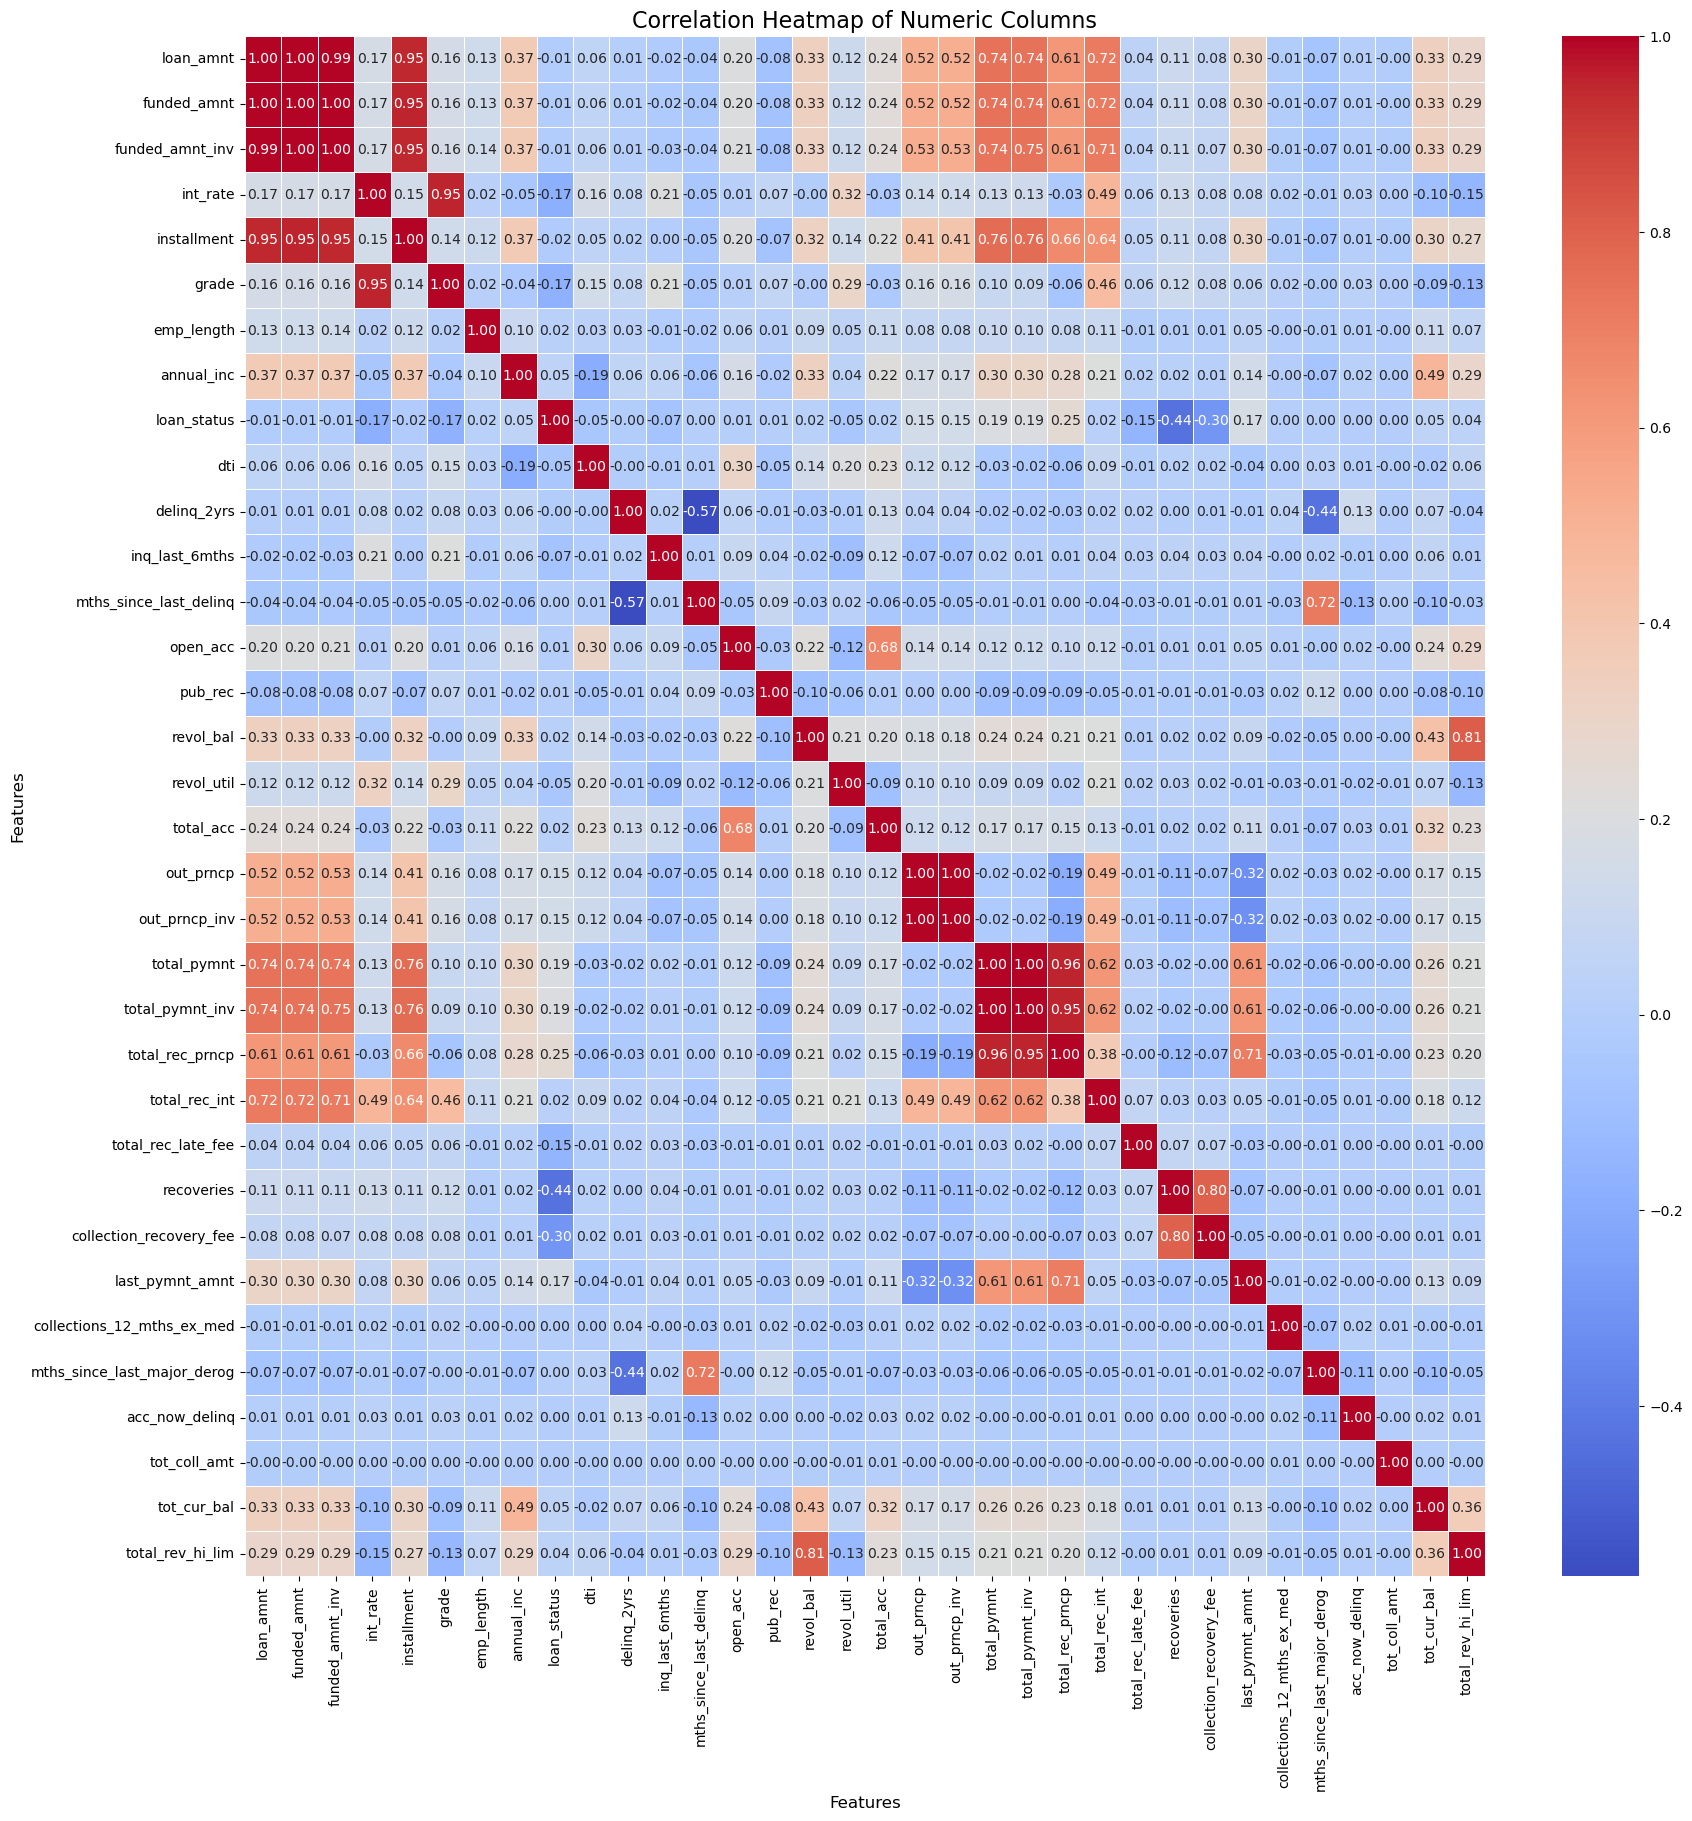

In [243]:
corr_matrix = clean.corr()
plt.figure(figsize=(20, 20))  # Set the size of the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Columns', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

Based on the heatmap, we can remove some irrelevant parametetes with high multicollinearity to make the future models simpler. Such features that can be removed are with correlation 0.9-1 as they are essentially the same parameters: loan_amt and funded_amn, total_payment and total payment_inv etc  

In [244]:
clean = clean.drop(['funded_amnt', 'funded_amnt_inv', 'total_pymnt_inv', 'out_prncp_inv', 'installment', 'total_rec_prncp'], axis=1)
print(clean.shape)

(466285, 28)


In [245]:
# Find columns with NaN values
missing_columns = clean.columns[clean.isna().any()]
# Print columns and their number of missing values
print("Columns with missing values:")
print(clean[missing_columns].isna().sum())

Columns with missing values:
annual_inc                          4
delinq_2yrs                        29
inq_last_6mths                     29
mths_since_last_delinq         250351
open_acc                           29
pub_rec                            29
revol_util                        340
total_acc                          29
collections_12_mths_ex_med        145
mths_since_last_major_derog    367311
acc_now_delinq                     29
tot_coll_amt                    70276
tot_cur_bal                     70276
total_rev_hi_lim                70276
dtype: int64


Fill the missing cells

In [246]:
columns_to_fill = ['annual_inc', 'inq_last_6mths', 'mths_since_last_delinq', 'pub_rec', 'total_acc', 'revol_util', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'open_acc']

for column in columns_to_fill:
    clean[column] = clean[column].fillna(clean[column].median())
clean['delinq_2yrs'] = clean['delinq_2yrs'].fillna(0)
clean.to_csv("clean_data.csv", index=False)
print(clean.shape)
#Now missing columns can be run again to see that no cells are missing

(466285, 28)


Apply Lasso

Start by setting target variables - loan status and the cleaned data as features. Also split training and testing set as 80-20

In [ ]:
X = clean.drop('loan_status', axis=1)  
y = clean['loan_status']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=9, stratify=y)

Since we have only 52186 default variables which is apx 11% we will use SMOTE

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=9)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

Perform Feature Selection using Logistic Regression with L1 Penalty

In [ ]:
log_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=9)
log_lasso.fit(X_train_res, y_train_res)
selected_features = np.array(X.columns)[log_lasso.coef_[0] != 0]

y_pred_proba = log_lasso.predict_proba(X_test)[:, 1]  # Probability of class 1
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert to binary predictions

Model Evaluation

In [275]:
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.6f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Selected Features: ['loan_amnt' 'int_rate' 'grade' 'emp_length' 'annual_inc' 'dti'
 'delinq_2yrs' 'inq_last_6mths' 'mths_since_last_delinq' 'open_acc'
 'pub_rec' 'revol_bal' 'revol_util' 'total_acc' 'out_prncp' 'total_pymnt'
 'total_rec_int' 'total_rec_late_fee' 'recoveries' 'last_pymnt_amnt'
 'collections_12_mths_ex_med' 'mths_since_last_major_derog'
 'acc_now_delinq' 'tot_coll_amt' 'tot_cur_bal' 'total_rev_hi_lim']
AUC Score: 0.965599

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.87     10437
           1       0.98      0.99      0.98     82820

    accuracy                           0.97     93257
   macro avg       0.94      0.91      0.92     93257
weighted avg       0.97      0.97      0.97     93257


Confusion Matrix:
 [[ 8771  1666]
 [ 1054 81766]]


Print and visualise the feature coefficient with non-zero values(For presentation need to check the meanings of each features)

In [ ]:
feature_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_lasso.coef_[0]
})
print(feature_coefficients)

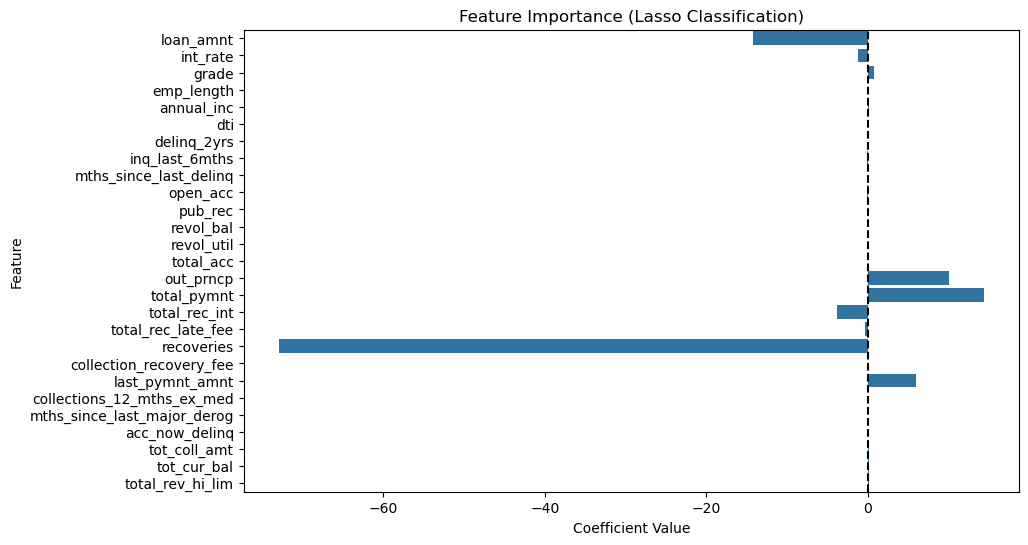

In [286]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=feature_coefficients["Coefficient"], 
    y=feature_coefficients["Feature"], 
)

plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance (Lasso Classification)")
plt.axvline(x=0, color="black", linestyle="--")
plt.show()

Now visualise the AUC plots

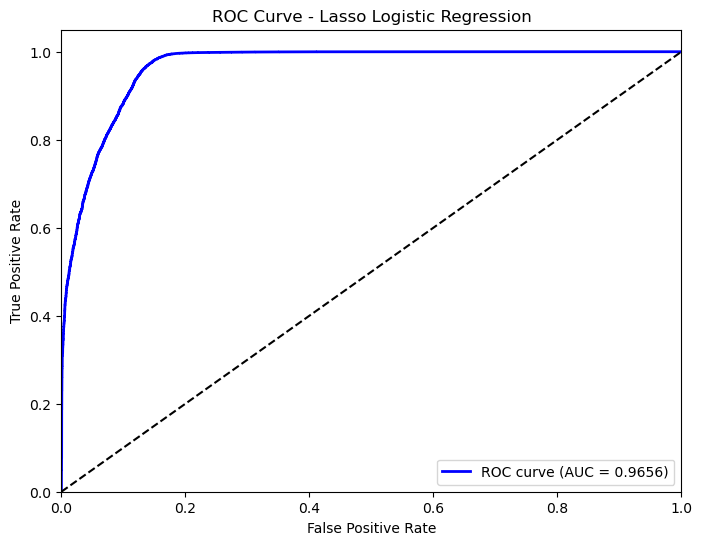

AUC Score: 0.9656


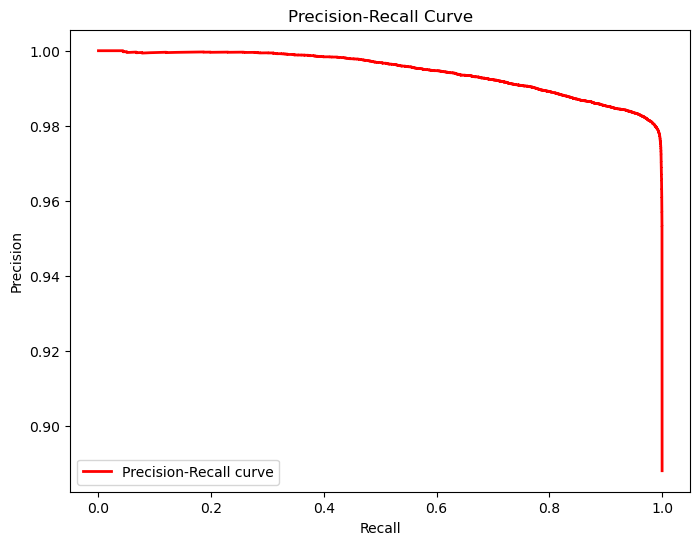

In [289]:
# Get probability estimates for the positive class (lasso.predict_proba gives probabilities)
y_pred_proba = log_lasso.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Lasso Logistic Regression')
plt.legend(loc="lower right")
plt.show()
print(f"AUC Score: {roc_auc:.4f}")

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, color='red', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

LGB model

In [269]:
X_train, X_test, y_train, y_test = train_test_split(clean.drop('loan_status', axis=1), y, test_size=0.2, random_state=9, stratify=y)
smote = SMOTE(sampling_strategy='auto', random_state=9) #since we have only 52186 default variables which is apx 11% we use SMOTE
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [270]:
train_data = lgb.Dataset(X_train_res, label=y_train_res)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
params = {
    'objective': 'binary',  # For classification tasks
    'metric': 'auc',  # AUC is useful for imbalanced datasets
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Trees
    'learning_rate': 0.05,
    'num_leaves': 31,  
    'max_depth': -1,  # No limit on tree depth
    'min_data_in_leaf': 20,  
    'feature_fraction': 0.8,  # Random feature selection
    'bagging_fraction': 0.8,  # Random row selection
    'bagging_freq': 5,  
    'verbose': -1,
    'random_state': 9
}
lgb_model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=1000,  # Number of trees
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
    ],  # Stop if validation AUC doesn’t improve
    
)

# Get probabilities (for AUC score)
y_pred_proba = lgb_model.predict(X_test)

# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate model performance
print("AUC Score:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[765]	valid_0's auc: 0.976372
AUC Score: 0.9763721089893046
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     10437
           1       0.98      1.00      0.99     82820

    accuracy                           0.98     93257
   macro avg       0.98      0.92      0.95     93257
weighted avg       0.98      0.98      0.98     93257



ROC and Precision-Recall plot

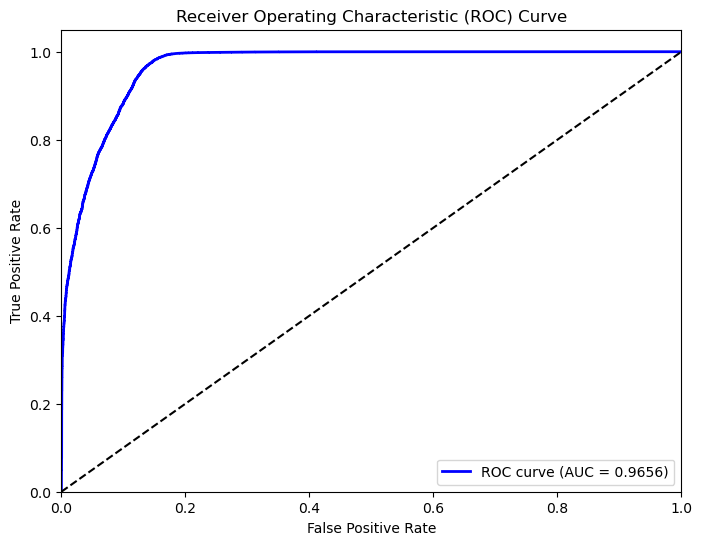

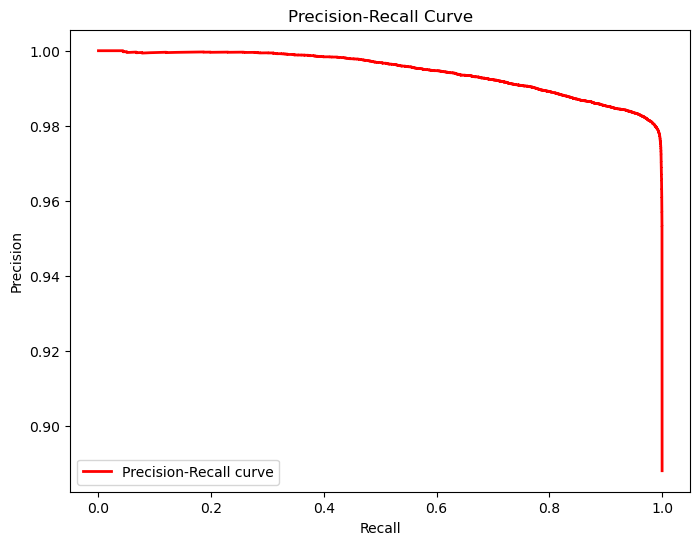

In [288]:

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, color='red', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()